Calculate climatological monthly variance for ESM2M historical and control

In [1]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
from utils import geo
import pandas as pd
import regionmask
from dask.diagnostics import ProgressBar
import glob
import os

In [2]:
dataset = 'esm2m-control'
variable = 'chl'
yearstart = 1
yearend = 300
monthorder = 'JANtoDEC'
averaging = 'wmean-latlon_climvar'

In [6]:
if dataset == 'esm2m-historical':
    rootdir = '/projects/SOCCOM/datasets/ESM2M/'
    local = 'archive/esm2m/ipcc_ar5/ESM2M-C1_all_historical_HC1/cmip5/GFDL-ESM2M/historical/mon/ocnBgchem/Omon/r1i1p1/v20110601/chl/'
    filename = 'chl_Omon_GFDL-ESM2M_historical_r1i1p1_*.nc'
    lonname,latname = 'rlon','rlat'
elif dataset == 'esm2m-control':
    rootdir = '/projects/SOCCOM/datasets/ESM2M_PPE/'
    local = 'archive/kbr/fre/verona/ESM2M/20161113/ANALYSIS/CONTROL/CHL/'
    filename = 'chl_*.nc'
    lonname,latname = 'xt_ocean','yt_ocean'

print('Opening.')
paths = glob.glob(rootdir+local+filename)
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = xr.open_mfdataset(paths,use_cftime=True)
ds = ds.sel({latname:slice(-80,-55)})
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,axes_dims_dict={'X':lonname,'Y':latname},periodic='X')
ds['area'] = ds['dxC']*ds['dyC']
ds = ds.chunk({'time':60})
ds

Opening.


<xarray.Dataset>
Dimensions:         (time: 3600, st_ocean: 50, yt_ocean: 25, xt_ocean: 360,
                     yu_ocean: 200, xu_ocean: 360, nv: 2, st_edges_ocean: 51,
                     xt_ocean_left: 360, yt_ocean_left: 25)
Coordinates: (12/14)
    geolat_c        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(25, 360), meta=np.ndarray>
    geolon_c        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(25, 360), meta=np.ndarray>
  * nv              (nv) float64 1.0 2.0
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.0 20.0 ... 5.133e+03 5.5e+03
    ...              ...
  * xt_ocean        (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * xu_ocean        (xu_ocean) float64 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * yt_ocean        (yt_ocean) float64 -79.5 -78.5 -77.5 ... -57.5 -56.5 -55.5
  * yu_ocean        (yu_ocean) float64 -81.0 -80.0 -79.0 ... 88.0 89.0 90.0
  * xt_ocean_left   (xt_ocean_left) float64 -280.0 -279.0 -278.0 ... 78.0 79.0
  * yt_ocean_left   (yt_ocean_left) float64 -80.0 -79.0 -78.0 ... -57.0 -56.0
Data variables:
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1      (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2      (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    chl             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 50, 25, 360), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(60, 2), meta=np.ndarray>
    dxG             (xt_ocean_left, yt_ocean) float64 dask.array<chunksize=(360, 25), meta=np.ndarray>
    dyG             (xt_ocean, yt_ocean_left) float64 dask.array<chunksize=(360, 25), meta=np.ndarray>
    dxC             (xt_ocean, yt_ocean) float64 dask.array<chunksize=(360, 25), meta=np.ndarray>
    dyC             (xt_ocean, yt_ocean) float64 dask.array<chunksize=(360, 25), meta=np.ndarray>
    rC              (xt_ocean, yt_ocean) float64 dask.array<chunksize=(360, 25), meta=np.ndarray>
    area            (xt_ocean, yt_ocean) float64 dask.array<chunksize=(360, 25), meta=np.ndarray>
Attributes:
    filename:   ocean_topaz_tracers_month.000101-000512.chl.nc
    title:      ESM2M_pi-control_topaz_C3_verona_NEWDIAG_V4
    grid_type:  mosaic
    grid_tile:  1
    history:    Sun Jul 12 03:29:04 2020: ncks -d time,0,11 ocean_topaz_trace...
    NCO:        4.0.3

In [8]:
# Shift to -180 to 180 in longitude
ds = ds.roll({lonname:-100},roll_coords=True)
newlon = ds[lonname].where(ds[lonname]>-180,ds[lonname]+360)
ds = ds.assign_coords({lonname:newlon})

In [9]:
# ds[variable].isel(time=0).plot(robust=True)

### By sector

In [10]:
# Regional averages
bound_dicts = {
    'PanAntarctic':None,
    'Weddell':[-60,20],
    'Indian':[20,90],
    'WestPacific':[90,160],
    'Ross':[160,-130],
    'AB':[-130,-60]
}

dsmean = xr.Dataset(coords = {'time':ds['time']})

for sector,bounds in bound_dicts.items():
    print(sector)
    # Specify bounds
    if sector=='PanAntarctic':
        cond = xr.ones_like(ds['area'])
    elif bounds[0]>bounds[1]:
        cond = (ds['geolon_t']>=bounds[0]) | (ds['geolon_t']<bounds[1])
    else:
        cond = (ds['geolon_t']>=bounds[0]) & (ds['geolon_t']<bounds[1])
    # Apply sector mask
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        dssector = ds.where(cond)
        
    dsmean[sector] = dssector[variable].weighted(dssector['area'].fillna(0)).mean([latname,lonname],skipna=True)

PanAntarctic
Weddell
Indian
WestPacific
Ross
AB


In [11]:
# Save to netcdf
outdir = '../../../data/'
yearstr = str(yearstart).zfill(4)+'-'+str(yearend).zfill(4)
averaging = 'wmean-latlon'
outpath = outdir+'.'.join([dataset,'monthly',averaging,monthorder,yearstr,'ForBuchovecky','nc'])
with ProgressBar():
    dsmean.to_netcdf(outpath,mode='w')

[########################################] | 100% Completed | 268.11 s


In [94]:
# Group by month and compute variance
dsvar = dsmean.groupby('time.month').std()**2
# and climatological mean
dsclim = dsmean.groupby('time.month').mean()

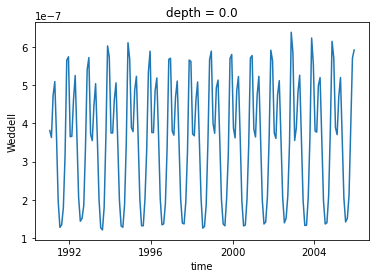

In [111]:
dsmean['Weddell'].plot()